In [1]:
from __future__ import division, print_function, unicode_literals
import numpy as np
import argparse
import os
import os.path as osp
import tqdm
import torch
import torch.utils.data
import torchvision.models as models
import torchvision.transforms as transforms
import glob
import torchvision
import PIL.Image
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn
import scipy.misc
import scipy.io as sio
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# HYPERPARAMS
max_iteration=100000
lr=1.0e-14
momentum=0.99
weight_decay=0.0005
interval_validate=4000
batch_size = 10

In [3]:
torch.cuda.set_device(1)
cuda = torch.cuda.is_available()

# to reproduce same results
torch.manual_seed(1337)
if cuda:
    torch.cuda.manual_seed(1337)

In [4]:
def genmatdemo(path,segment):
    W,H = segment.size
    segment = np.array(segment.getdata()).reshape(H,W)
#     print(segment.shape)
    mat = sio.loadmat(path)
    #ADD A POSE FOR HIP CENTER? OR HEURISTIC ON SEGMENT BOUNDS
    limbs = [[0,1],[1,2],[2,3],[3,4],[1,5],[5,6],[6,7],[1,8],[8,9],[9,10],[1,11],[11,12],[12,13]]
    out = np.zeros((14,H,W))
#     print(out[0].shape)
    pafx = np.zeros((H,W))
#     print(pafx.shape)
    pafy = np.zeros((H,W))
    x, y = np.meshgrid(np.arange(W), np.arange(H))
#     y = np.flipud(y)
#     print(x.shape)
    for human in mat['joints'][0]:
        poselist = np.around(human[:,:-1]).astype(np.int64)
        vis = human[:,2]
        #PAF GT
        for limb in limbs:
            p1 = poselist[limb[0],:]
            p2 = poselist[limb[1],:]
            dvec = (p2-p1)/np.linalg.norm(p2-p1)
            if not (vis[limb[0]]==0 or vis[limb[1]]==0):
#             if (np.all(p1>0) and np.all(p2>0)):
                #APPROX RECON
                vecx = x - p1[0]
                vecy = y - p1[1]
                dot = vecx*dvec[0] + vecy*dvec[1]
                perp2 = vecx**2+vecy**2-dot**2
                boolmat = (dot>0) & (dot<np.linalg.norm(p2-p1)) & (perp2<np.linalg.norm(p2-p1)*0.3) #sigma^2
                pafx[boolmat] = 255*dvec[0]
                pafy[boolmat] = 255*dvec[1]
#             else:
#                 mp = np.around((p1+p2)/2.0).astype(np.uint8)
#                 midval = segment[mp[1],mp[0]]
#                 pafx[segment==midval] = dvec[0]
#                 pafy[segment==midval] = dvec[1]
        #POSE GT
        for (i,pose) in enumerate(poselist):
            tmp = 255*np.exp(-((x-pose[0])**2 + (y-pose[1])**2)/(2.0*50.0))
            out[0] = np.maximum(out[0],tmp)
#             print(human[i])
        out[0]=np.maximum(out[0],pafx+pafy)
    return out,pafx,pafy
    

/data/gpu/abhiagwl/miniconda2/envs/abhinav/lib/python2.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


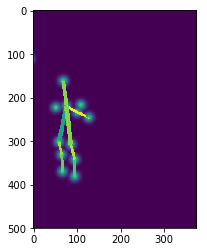

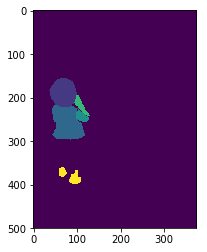

In [5]:
# DEMO
segment = PIL.Image.open('/extra_data/ayushya/pascal_data/pascal_data/SegmentationPart/2009_000544.png')
out,pafx,pafy = genmatdemo('/extra_data/ayushya/pascal_data/pascal_data/PersonJoints/2009_000544.mat',segment)
plt.figure()
plt.imshow(out[0])
# plt.figure()
# plt.imshow(pafx)
plt.figure()
plt.imshow(segment)

In [8]:
def genmat(path,segment):
    W,H = segment.size
    segment = np.array(segment.getdata()).reshape(H,W)
#     print(segment.shape)
    mat = sio.loadmat(path)
    #ADD A POSE FOR HIP CENTER? OR HEURISTIC ON SEGMENT BOUNDS
    limbs = [[0,1],[1,2],[2,3],[3,4],[1,5],[5,6],[6,7],[1,8],[8,9],[9,10],[1,11],[11,12],[12,13]]
    out = np.zeros((14,H,W))
#     print(out[0].shape)
    paf = np.zeros((13,2,H,W))
#     print(pafx.shape)
    x, y = np.meshgrid(np.arange(W), np.arange(H))
#     y = np.flipud(y)
#     print(x.shape)
    for human in mat['joints'][0]:
        poselist = np.around(human[:,:-1]).astype(np.int64)
        vis = human[:,2]
        #PAF GT
        for (i,limb) in enumerate(limbs):
            p1 = poselist[limb[0],:]
            p2 = poselist[limb[1],:]
            dvec = (p2-p1)/np.linalg.norm(p2-p1)
            if not (vis[limb[0]]==0 or vis[limb[1]]==0):
#             if (np.all(p1>0) and np.all(p2>0)):
                #APPROX RECON
                vecx = x - p1[0]
                vecy = y - p1[1]
                dot = vecx*dvec[0] + vecy*dvec[1]
                perp2 = vecx**2+vecy**2-dot**2
                boolmat = (dot>0) & (dot<np.linalg.norm(p2-p1)) & (perp2<np.linalg.norm(p2-p1)*0.3) #sigma^2
                paf[i][0][boolmat] = 255*dvec[0]
                paf[i][1][boolmat] = 255*dvec[1]
#             else:
#                 mp = np.around((p1+p2)/2.0).astype(np.uint8)
#                 midval = segment[mp[1],mp[0]]
#                 pafx[segment==midval] = dvec[0]
#                 pafy[segment==midval] = dvec[1]
        #POSE GT
        for (i,pose) in enumerate(poselist):
            tmp = 255*np.exp(-((x-pose[0])**2 + (y-pose[1])**2)/(2.0*50.0))
            out[i] = np.maximum(out[i],tmp)
#             print(human[i])
#         out[0]=np.maximum(out[0],pafx+pafy)
    return out,paf
    

In [9]:
# DEMO
segment = PIL.Image.open('/extra_data/ayushya/pascal_data/pascal_data/SegmentationPart/2009_000544.png')
out,paf = genmat('/extra_data/ayushya/pascal_data/pascal_data/PersonJoints/2009_000544.mat',segment)
print(paf.shape)

(13, 2, 500, 375)


/data/gpu/abhiagwl/miniconda2/envs/abhinav/lib/python2.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


In [ ]:
from numpy import ma
U = pafx[0]
V = pafy[0]
segment = PIL.Image.open('/extra_data/ayushya/pascal_data/pascal_data/SegmentationPart/2009_000544.png')
W,H = segment.size
segment = np.array(segment.getdata()).reshape(H,W)
X, Y = np.meshgrid(np.arange(U.shape[1]), np.arange(U.shape[0]))
# 1
plt.figure()
plt.imshow(segment, alpha = .5)
s = 5
Q = plt.quiver(X[::s], Y[::s], U[::s], V[::s], 
               scale=100, headaxislength=4, alpha=.5, width=0.001, color='r')

fig = plt.gcf()
fig.set_size_inches(10, 10)

In [13]:
class CDATA(torch.utils.data.Dataset): # Extend PyTorch's Dataset class
    def __init__(self, root_dir, train, transform=None):
        if(train):
            rfile = root_dir+'pascal_data/pascal_data/train_idnew.txt'
        else :
            rfile = root_dir+'pascal_data/pascal_data/val_idnew.txt'
        ldir = root_dir + 'VOCdevkit/VOC2010/JPEGImages/'
        sdir = root_dir + 'pascal_data/pascal_data/SegmentationPart/'
        pdir = root_dir + 'pascal_data/pascal_data/PersonJoints/'
        self.transform = transform
        self.img = []
        self.seg = []
        self.mat = []
        
        with open(rfile,'r') as f:
            for line in f:
                    line = line[:-1]
#                     print(line)
                    self.img.append(ldir+line+'.jpg')
                    self.seg.append(sdir+line+'.png')
                    self.mat.append(pdir+line+'.mat')
#             PUT DATA IN CORRESPONDING VARS
            
            
#             self.label.append(ord(file_path.split('/')[-2]) - ord('A')) #ord makes A,B,C.. to 0,1,2,.. respectively

            
    def __len__(self):
        # return the size of the dataset (total number of images) as an integer
        # this should be rather easy if you created a mapping in __init__
        return len(self.img)
        
    def __getitem__(self, idx):
        # idx - the index of the sample requested
        #
        # Open the image correspoding to idx, apply transforms on it and return a tuple (image, label)
        # where label is an integer from 0-9 (since notMNIST has 10 classes)
        image = PIL.Image.open(self.img[idx])
        segment = PIL.Image.open(self.seg[idx])
        poset,paft = genmat(self.mat[idx],segment)
        if self.transform is None:
            return (image,segment,poset,paft)
        else:
            img_transformed = self.transform(image)
#             RETURN VARS
            return (img_transformed,segment,poset,paft)


In [14]:
composed_transform = transforms.Compose([transforms.Scale((224,224)),transforms.ToTensor()])
train_dataset = CDATA(root_dir='/extra_data/ayushya/', train=True, transform=composed_transform) # Supply proper root_dir
test_dataset = CDATA(root_dir='/extra_data/ayushya/', train=False, transform=composed_transform) # Supply proper root_dir

print('Size of train dataset: %d' % len(train_dataset))
print('Size of test dataset: %d' % len(test_dataset))


kwargs = {'num_workers': 4, 'pin_memory': True} if cuda else {}

# Create loaders for the dataset
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, **kwargs)


Size of train dataset: 1696
Size of test dataset: 1797


In [ ]:
class suhpos(nn.Module):
    def __init__(self, pretrained_model):
        super(suhpos, self).__init__()
        self.features = pretrained_model.features
        self.poselayer = nn.Sequential(
            nn.Conv2d(512, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(True),
            nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(True),
            nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(True),
            nn.Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1)),
            nn.ReLU(True),
            nn.Conv2d(512, 14, kernel_size=(1, 1), stride=(1, 1)),
        )
        self.paflayer = nn.Sequential(
            nn.Conv2d(512, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(True),
            nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(True),
            nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(True),
            nn.Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1)),
            nn.ReLU(True),
            nn.Conv2d(512, 13, kernel_size=(1, 1), stride=(1, 1)),
        )
        self.seglayer = nn.Sequential(
            nn.Conv2d(512, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(True),
            nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(True),
            nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(True),
            nn.Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1)),
            nn.ReLU(True),
            nn.Conv2d(512, 7, kernel_size=(1, 1), stride=(1, 1)),
        )

    def forward(self, x):
        f = self.features(x)
        pose = self.poselayer(f)
        paf = self.paflayer(f)
        seg = self.seglayer(f)
        return pose,paf,seg


In [ ]:
# MODEL
# DEFINE MODEL
# model = torchfcn.models.FCN8s(n_class=21)
vgg19 = models.vgg19(pretrained=True)
model = suhpos(vgg19)
print(model)

resume = 0

start_epoch = 0
start_iteration = 0
if cuda:
    model = model.cuda()


In [ ]:
# LOSS
loss1 = nn.MSELoss()
loss2 = nn.MSELoss()

def cross_entropy2d(input, target, weight=None, size_average=True):
    # input: (n, c, h, w), target: (n, h, w)
    n, c, h, w = input.size()
    # log_p: (n, c, h, w)
    log_p = F.log_softmax(input)
    # log_p: (n*h*w, c)
#     log_p = log_p.transpose(1, 2).transpose(2, 3).contiguous().view(-1, c)
#     log_p = log_p[target.view(n, h, w, 1).repeat(1, 1, 1, c) >= 0]
#     log_p = log_p.view(-1, c)
    # target: (n*h*w,)
#     mask = target >= 0
#     target = target[mask]
    loss = F.nll_loss(log_p, target, weight=weight, size_average=False)
    if size_average:
        loss /= mask.data.sum()
    return loss


In [ ]:
# OPTIMIZER
optim = torch.optim.SGD(
    model.parameters(),
    lr=lr,
    momentum=momentum,
    weight_decay=weight_decay)

In [ ]:
# VALIDATION
def validate(iteration):
        val_loss = 0
        label_trues, label_preds = [], []
        for batch_idx, (data, target) in tqdm.tqdm(
                enumerate(test_loader), total=len(test_loader),
                desc='Valid iteration=%d' % iteration, ncols=80,
                leave=False):
            
#             INSERT TARGETS
            if self.cuda:
                data, target = data.cuda(), target.cuda()
            data, target = Variable(data, volatile=True), Variable(target)
            score = self.model(data)

            loss = cross_entropy2d(score, target)
            if np.isnan(float(loss.data[0])):
                raise ValueError('loss is nan while validating')
            
            val_loss += float(loss.data[0]) / len(data)

#             imgs = data.data.cpu()
#             lbl_pred = score.data.max(1)[1].cpu().numpy()[:, :, :]
#             lbl_true = target.data.cpu()
                
#         SAVE IMAGES        
#         out = "val_out/"
#         if not osp.exists(out):
#             os.makedirs(out)
#         out_file = osp.join(out, 'iter%.jpg' % iteration)
#         scipy.misc.imsave(out_file, image)

        val_loss /= len(test_loader)

        

In [ ]:
# TRAINING
def train_model():
    max_epoch = int(math.ceil(1. * max_iter / len(train_loader)))
    for epoch in tqdm.trange(0, max_epoch,
                             desc='Train', ncols=80):
#         INSERT TARGETS
        for batch_idx, (data, target) in tqdm.tqdm( 
                enumerate(train_loader), total=len(train_loader),
                desc='Train epoch=%d' % epoch, ncols=80, leave=False):
            iteration = batch_idx + epoch * len(train_loader)
            
#             VALIDATE
#             if iteration % interval_validate == 0:
#                 validate(iteration)

#             MODIFY FOR TARGETS
            if self.cuda:
                data, target = data.cuda(), target.cuda()
            data, target = Variable(data), Variable(target)
            optim.zero_grad()
#             MODIFY FOR OUTPUTS
            pose,paf,seg = model(data)

            loss = cross_entropy2d(seg, )
            loss /= len(data)
            if np.isnan(float(loss.data[0])):
                raise ValueError('loss is nan while training')
            loss.backward()
            optim.step()

#             METRICS
#             metrics = []
#             lbl_pred = score.data.max(1)[1].cpu().numpy()[:, :, :]
#             lbl_true = target.data.cpu().numpy()
#             for lt, lp in zip(lbl_true, lbl_pred):
#                 acc, acc_cls, mean_iu, fwavacc = \
#                     torchfcn.utils.label_accuracy_score(
#                         [lt], [lp], n_class=n_class)
#                 metrics.append((acc, acc_cls, mean_iu, fwavacc))
#             metrics = np.mean(metrics, axis=0)

            if iteration >= max_iter:
                break

